In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Read the flights data
flights = pd.read_csv('data/flights.csv')

In [24]:
#Checking what we have
flights.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,DestAirportName,DestCity,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,John F. Kennedy International,New York,NY,1539,4,0.0,1824,13,0,0
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,Chicago Midway International,Chicago,IL,710,3,0.0,740,22,1,0
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,Ronald Reagan Washington National,Washington,DC,810,-3,0.0,1614,-7,0,0
3,2013,7,22,1,OO,13930,Chicago O'Hare International,Chicago,IL,11042,Cleveland-Hopkins International,Cleveland,OH,804,35,1.0,1027,33,1,0
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,Hartsfield-Jackson Atlanta International,Atlanta,GA,545,-1,0.0,728,-9,0,0


In [25]:
# Convert individual date components to datetime
flights['DateTime'] = pd.to_datetime(
    {
        'year': flights['Year'],
        'month': flights['Month'],
        'day': flights['DayofMonth']
    }
)

# Format the datetime to MM-DD-YYYY
#flights['DateTime'] = flights['DateTime'].dt.strftime('%m-%d-%Y')
flights['DateTime'] = flights['DateTime'].dt.strftime('%Y-%m-%d')

In [26]:
# Get list of columns in flights
columns = flights.columns.tolist()
print(columns)

['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier', 'OriginAirportID', 'OriginAirportName', 'OriginCity', 'OriginState', 'DestAirportID', 'DestAirportName', 'DestCity', 'DestState', 'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrDelay', 'ArrDel15', 'Cancelled', 'DateTime']


In [27]:
#checking again for some reason i cant recall
flights.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,...,DestCity,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled,DateTime
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,...,New York,NY,1539,4,0.0,1824,13,0,0,2013-09-16
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,...,Chicago,IL,710,3,0.0,740,22,1,0,2013-09-23
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,...,Washington,DC,810,-3,0.0,1614,-7,0,0,2013-09-07
3,2013,7,22,1,OO,13930,Chicago O'Hare International,Chicago,IL,11042,...,Cleveland,OH,804,35,1.0,1027,33,1,0,2013-07-22
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,...,Atlanta,GA,545,-1,0.0,728,-9,0,0,2013-05-16


In [28]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder and encode Carrier

# Create and fit label encoder for Carrier
carrier_encoder = LabelEncoder()
flights['Carrier_Encoded'] = carrier_encoder.fit_transform(flights['Carrier'])


In [29]:
# Create a dictionary mapping carriers to their encoded values
carrier_mapping = dict(zip(flights['Carrier'].unique(), flights['Carrier_Encoded'].unique()))
print("Carrier Encoding Dictionary:")
for carrier, encoded in sorted(carrier_mapping.items()):
    print(f"'{carrier}': {encoded}")

Carrier Encoding Dictionary:
'9E': 0
'AA': 1
'AS': 2
'B6': 3
'DL': 4
'EV': 5
'F9': 6
'FL': 7
'HA': 8
'MQ': 9
'OO': 10
'UA': 11
'US': 12
'VX': 13
'WN': 14
'YV': 15


In [30]:
flights.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,...,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled,DateTime,Carrier_Encoded
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,...,NY,1539,4,0.0,1824,13,0,0,2013-09-16,4
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,...,IL,710,3,0.0,740,22,1,0,2013-09-23,14
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,...,DC,810,-3,0.0,1614,-7,0,0,2013-09-07,2
3,2013,7,22,1,OO,13930,Chicago O'Hare International,Chicago,IL,11042,...,OH,804,35,1.0,1027,33,1,0,2013-07-22,10
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,...,GA,545,-1,0.0,728,-9,0,0,2013-05-16,4


In [31]:
# Check for missing values
print("Missing values in each column:")
print(flights.isnull().sum())
print("\nTotal missing values:", flights.isnull().sum().sum())

# Check for duplicates
print("\nDuplicate rows:", flights.duplicated().sum())

Missing values in each column:
Year                    0
Month                   0
DayofMonth              0
DayOfWeek               0
Carrier                 0
OriginAirportID         0
OriginAirportName       0
OriginCity              0
OriginState             0
DestAirportID           0
DestAirportName         0
DestCity                0
DestState               0
CRSDepTime              0
DepDelay                0
DepDel15             2761
CRSArrTime              0
ArrDelay                0
ArrDel15                0
Cancelled               0
DateTime                0
Carrier_Encoded         0
dtype: int64

Total missing values: 2761

Duplicate rows: 0


In [32]:
flights['DepDel15'] = flights['DepDel15'].fillna(0)

In [33]:
# Check for missing values
print("Missing values in each column:")
print(flights.isnull().sum())
print("\nTotal missing values:", flights.isnull().sum().sum())

Missing values in each column:
Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
Carrier              0
OriginAirportID      0
OriginAirportName    0
OriginCity           0
OriginState          0
DestAirportID        0
DestAirportName      0
DestCity             0
DestState            0
CRSDepTime           0
DepDelay             0
DepDel15             0
CRSArrTime           0
ArrDelay             0
ArrDel15             0
Cancelled            0
DateTime             0
Carrier_Encoded      0
dtype: int64

Total missing values: 0


In [34]:
# Calculate 90th percentile for DepDelay
percentile_90 = flights['DepDelay'].quantile(0.90)

# Remove rows where DepDelay is higher than 90th percentile
flights = flights[flights['DepDelay'] <= percentile_90]

In [35]:
#Dont need them in the model
flights = flights.drop(['OriginAirportName', 'DestAirportName'], axis=1)

In [36]:
flights.shape

(245192, 20)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Select features and target
X = flights[['Carrier_Encoded','DayofMonth','DayOfWeek','Month','DestAirportID','OriginAirportID']]
#airport id
#YEAR-MONTH-DAY

y = flights['ArrDel15']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Print model accuracy
print(f"Training accuracy: {model.score(X_train_scaled, y_train):.5f}")
print(f"Testing accuracy: {model.score(X_test_scaled, y_test):.5f}")

Training accuracy: 0.86835
Testing accuracy: 0.87049


In [38]:
# Get predictions probabilities for all test cases
y_test_probs = model.predict_proba(X_test_scaled)

# Pick a random index from test set
random_idx = np.random.randint(len(X_test))

print(len(X_test))

# Get the probabilities for that sample
sample_prob = y_test_probs[random_idx]
print(sample_prob)
# Get the actual test case details
test_case = X_test.iloc[random_idx]

print("Flight Details:")
print("--------------")
print(f"Carrier (encoded): {test_case['Carrier_Encoded']}")
print(f"Day of Month: {test_case['DayofMonth']}")
print(f"Day of Week: {test_case['DayOfWeek']}")
print(f"Month: {test_case['Month']}")
print(f"Origin Airport ID: {test_case['OriginAirportID']}")
print(f"Destination Airport ID: {test_case['DestAirportID']}")
print("\nPrediction Probabilities:")
print("-----------------------")
print(f"Probability of On-Time: {sample_prob[0]:.2%}")
print(f"Probability of Delay: {sample_prob[1]:.2%}")
print(f"\nActual Outcome: {'Delayed' if y_test.iloc[random_idx] == 1 else 'On-Time'}")

49039
[0.84388728 0.15611272]
Flight Details:
--------------
Carrier (encoded): 14
Day of Month: 11
Day of Week: 2
Month: 6
Origin Airport ID: 12191
Destination Airport ID: 13232

Prediction Probabilities:
-----------------------
Probability of On-Time: 84.39%
Probability of Delay: 15.61%

Actual Outcome: On-Time


In [39]:
import pickle

# Save the model to a file
with open('fd_model_logistric_regression.pkl', 'wb') as file:
    pickle.dump(model, file)

# Also save the scaler since we'll need it for future predictions
with open('fd_model_logistric_regression_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

[0.84388728 0.15611272]


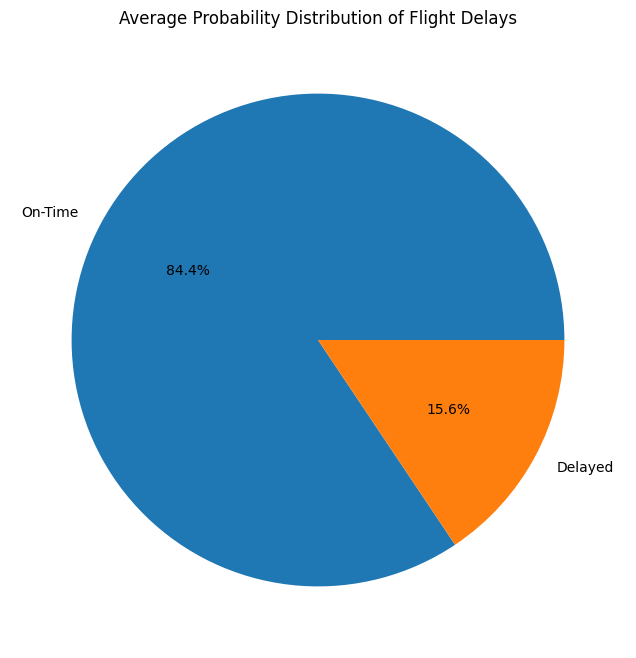

In [40]:
# Create a pie chart of average prediction probabilities
avg_probs = y_test_probs[random_idx]

print(avg_probs)
plt.figure(figsize=(8, 8))
plt.pie(avg_probs, labels=['On-Time', 'Delayed'], autopct='%1.1f%%')
plt.title('Average Probability Distribution of Flight Delays')
plt.show()

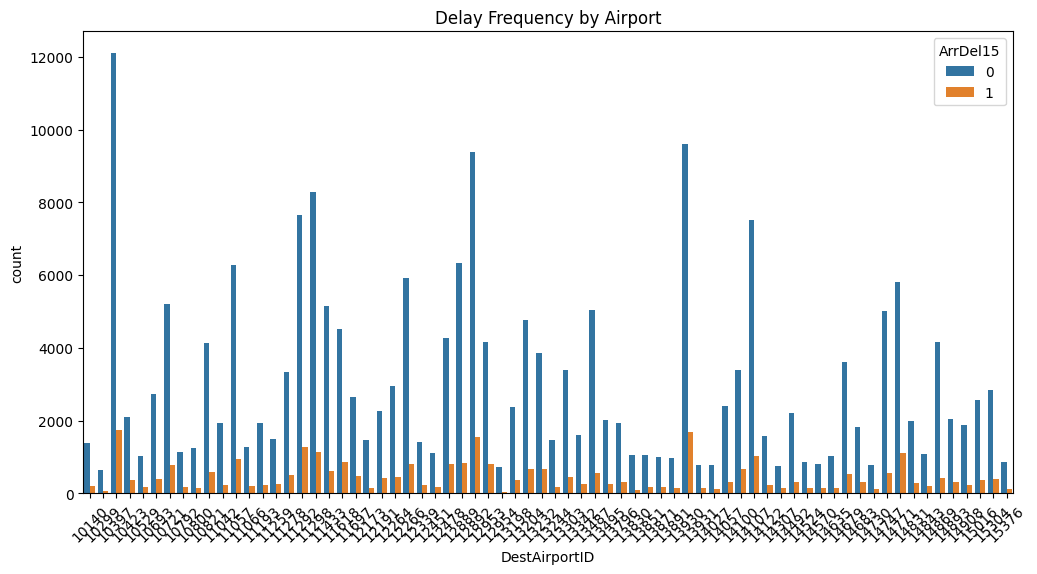

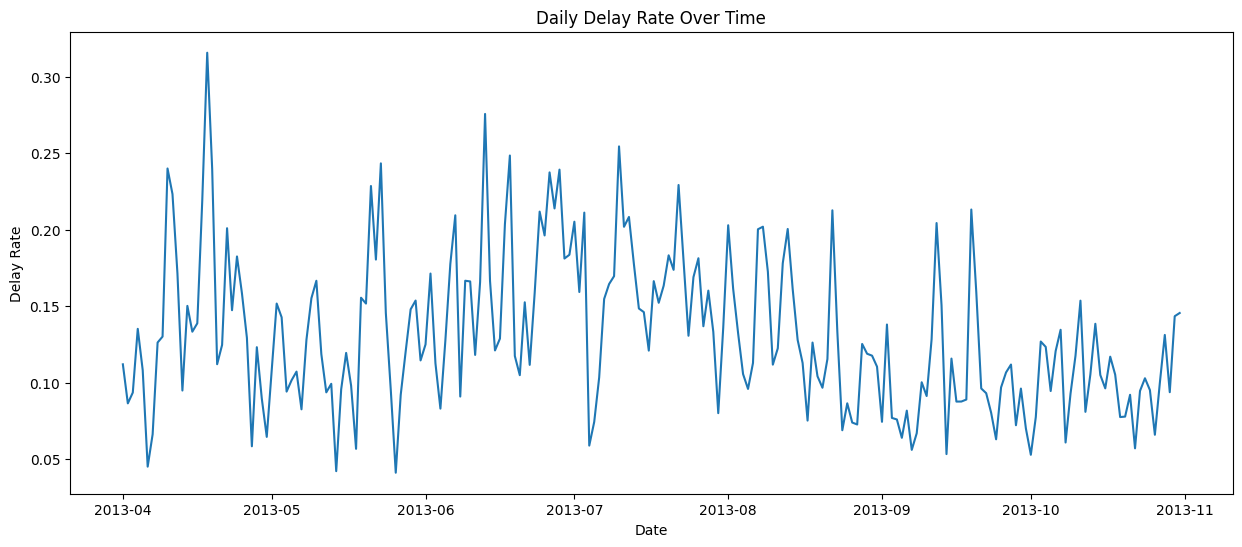

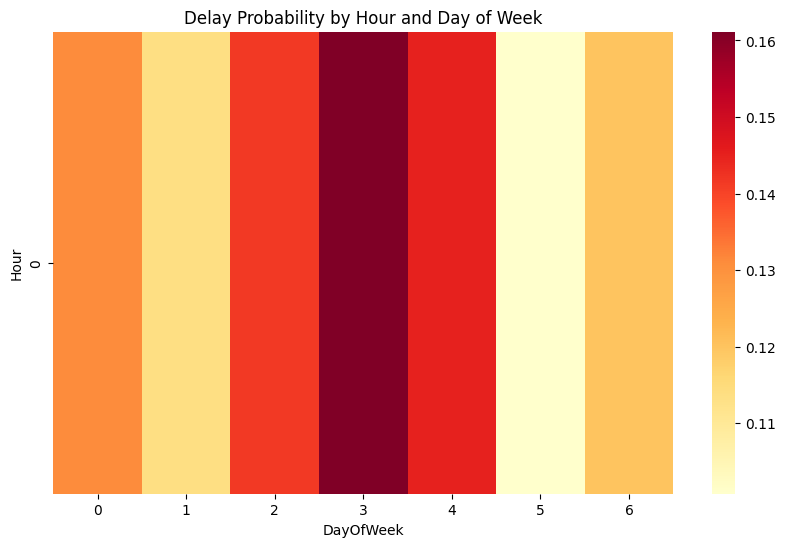

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar plot of delay frequency by airport
plt.figure(figsize=(12, 6))
sns.countplot(data=flights, x='DestAirportID', hue='ArrDel15')
plt.title('Delay Frequency by Airport')
plt.xticks(rotation=45)
plt.show()

# 2. Time series of delays
plt.figure(figsize=(15, 6))
flights['Date'] = pd.to_datetime(flights['DateTime']).dt.date
daily_delays = flights.groupby('Date')['ArrDel15'].mean()
plt.plot(daily_delays.index, daily_delays.values)
plt.title('Daily Delay Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Delay Rate')
plt.show()

# 3. Heatmap of delays by hour and day
plt.figure(figsize=(10, 6))
flights['Hour'] = pd.to_datetime(flights['DateTime']).dt.hour
flights['DayOfWeek'] = pd.to_datetime(flights['DateTime']).dt.dayofweek
delay_pivot = flights.pivot_table(
    values='ArrDel15', 
    index='Hour',
    columns='DayOfWeek',
    aggfunc='mean'
)
sns.heatmap(delay_pivot, cmap='YlOrRd')
plt.title('Delay Probability by Hour and Day of Week')
plt.show()

In [42]:
import pickle
import numpy as np

# Load the saved model and scaler
with open('fd_model_logistric_regression.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
    
with open('fd_model_logistric_regression_scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

# Create a random test case
random_test_case = {
    'Carrier_Encoded': np.random.randint(0, 15),
    'DayofMonth': np.random.randint(1, 32),
    'DayOfWeek': np.random.randint(0, 7),
    'Month': np.random.randint(1, 13),
    'DestAirportID': X['DestAirportID'].sample().iloc[0],
    'OriginAirportID': X['OriginAirportID'].sample().iloc[0]
}

# Convert to DataFrame with same structure as training data
test_input = pd.DataFrame([random_test_case])

# Scale the input
scaled_input = loaded_scaler.transform(test_input)

# Make prediction
prediction_prob = loaded_model.predict_proba(scaled_input)[0]

print("Flight Details:")
print("--------------")
for key, value in random_test_case.items():
    print(f"{key}: {value}")

print("\nPrediction Probabilities:")
print("-----------------------")
print(f"Probability of On-Time: {prediction_prob[0]:.2%}")
print(f"Probability of Delay: {prediction_prob[1]:.2%}")

Flight Details:
--------------
Carrier_Encoded: 13
DayofMonth: 3
DayOfWeek: 3
Month: 12
DestAirportID: 13830
OriginAirportID: 12266

Prediction Probabilities:
-----------------------
Probability of On-Time: 88.99%
Probability of Delay: 11.01%


## Now with Neural Networks

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn

# Custom dataset class
class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the neural network
class FlightNet(nn.Module):
    def __init__(self, input_size):
        super(FlightNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

# Create datasets
train_dataset = FlightDataset(X_train_scaled, y_train)
test_dataset = FlightDataset(X_test_scaled, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model, loss and optimizer
model = FlightNet(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
    
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10], Loss: 0.3904
Epoch [2/10], Loss: 0.3873
Epoch [3/10], Loss: 0.3868
Epoch [4/10], Loss: 0.3861
Epoch [5/10], Loss: 0.3855
Epoch [6/10], Loss: 0.3850
Epoch [7/10], Loss: 0.3847
Epoch [8/10], Loss: 0.3843
Epoch [9/10], Loss: 0.3842
Epoch [10/10], Loss: 0.3838
Test Accuracy: 87.05%


In [44]:
# Save the PyTorch model
torch.save(model.state_dict(), 'fd_model_neural_network.pt')
